# Use `Networkit` to speed up calculations


In [1]:
import networkit as nk
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import powerlaw

from utils import plot_powerlaw, show_weight

In [2]:
# Save index of the artists
ARTISTS_BY_INDEX: dict = {}
ARTISTS_BY_NAME: dict = {}

# Reduce graph using `Graph Sampling` and `Edge Shedding`


In [3]:
def update_artists(graph) -> nk.Graph:
    global ARTISTS_BY_INDEX
    global ARTISTS_BY_NAME

    artist_by_name = {}
    artist_by_index = {}
    iter = graph.iterNodes()
    G = nk.Graph(weighted=True, directed=False)
    for i, node in enumerate(iter):
        artist = ARTISTS_BY_INDEX[node]  # type: ignore
        artist_by_index[i] = artist
        artist_by_name[artist] = i
        G.addNode()
    iter = graph.iterEdges()
    for u, v in iter:
        n_u = artist_by_name[ARTISTS_BY_INDEX[u]]  # type: ignore
        n_v = artist_by_name[ARTISTS_BY_INDEX[v]]  # type: ignore
        n_weight = graph.weight(u, v)
        G.addEdge(n_u, n_v, n_weight)
    # Update maps
    ARTISTS_BY_INDEX = artist_by_index
    ARTISTS_BY_NAME = artist_by_name
    return G

## graph sampling


In [ ]:
def graph_sampling(G, sample_size):
    # Calcular el grado de cada nodo
    degrees = {i: G.degree(i) for i in range(G.numberOfNodes())}
    # Crear una lista de nodos y sus grados
    nodes = list(range(G.numberOfNodes()))
    node_degrees = [degrees[n] for n in nodes]
    # Calcular la probabilidad de selección basada en el grado
    total_degree = sum(node_degrees)
    probabilities = [degree / total_degree for degree in node_degrees]
    # Seleccionar nodos de manera aleatoria pero ponderada por su grado
    sampled_nodes = np.random.choice(
        nodes, size=sample_size, replace=False, p=probabilities
    )
    # Crear el subgrafo con los nodos seleccionados
    sampled_graph = nk.graphtools.subgraphFromNodes(G, sampled_nodes)
    # Set weights
    iter = sampled_graph.iterEdges()
    for u, v in iter:
        weight = G.weight(u, v)
        if weight == 0:
            continue
        sampled_graph.setWeight(u, v, weight)

    # Map graph again
    sampled_graph = update_artists(sampled_graph)
    # Mostrar estadísticas del grafo reducido
    print(
        f"Nodos originales: {G.numberOfNodes()}, Nodos reducidos: {sampled_graph.numberOfNodes()}"
    )
    print(
        f"Aristas originales: {G.numberOfEdges()}, Aristas reducidas: {sampled_graph.numberOfEdges()}"
    )
    return sampled_graph

## Edge shedding


In [ ]:
def edge_shedding(graph):
    # Indexar edges
    graph.indexEdges()
    # Obtener aristas del grafo con networkit
    betweenness = nk.centrality.Betweenness(graph)
    betweenness.run()
    edge_betweenness = betweenness.edgeScores()

    iter = graph.iterEdges()
    # Obtener aristas con pesos en una línea
    edges = [(u, v, graph.weight(u, v)) for u, v in iter]
    # Asegurarse de que los IDs de las aristas estén dentro del rango
    edges_sorted = sorted(
        edges,
        key=lambda e: (
            edge_betweenness[graph.edgeId(e[0], e[1])]
            if graph.edgeId(e[0], e[1]) < len(edge_betweenness)
            else 0), reverse=True)
    p = 0.6  # Proporción de aristas a preservar
    num_edges_to_keep = int(p * graph.numberOfEdges())
    # Crear el grafo reducido
    G_reduced = nk.graph.Graph(weighted=True, directed=False)
    # Agregar las aristas preservadas al grafo reducido
    for i in range(num_edges_to_keep):
        u, v, w = edges_sorted[i]
        G_reduced.addEdge(u, v, w, addMissing=True)
    # Eliminar los nodos con degree 0
    G_reduced.indexEdges()
    G_reduced.forNodes(
        lambda u: G_reduced.removeNode(u) if G_reduced.degree(u) == 0 else None
    )
    # Map graph again
    G_reduced = update_artists(G_reduced)
    # Mostrar estadísticas del grafo reducido
    print(f"Aristas eliminadas: {len(edges_sorted) - num_edges_to_keep}")
    print(f"Nodos: {G_reduced.numberOfNodes()}, Aristas: {G_reduced.numberOfEdges()}")
    return G_reduced

# Process data


## Read `CSV`'s and join


In [6]:
# read with networkx
filename = f"../datasets/edges/ArtistW.csv"
print(f"Reading {filename}")
G = nx.read_edgelist(
    filename,
    nodetype=str,
    delimiter=";",
    create_using=nx.Graph(),
    data=(("weight", int),),  # type: ignore
)

Reading ../datasets/edges/ArtistW.csv


In [7]:
for i, node in enumerate(G):
    ARTISTS_BY_INDEX[i] = node
    ARTISTS_BY_NAME[node] = i

In [8]:
# Create an empty Networkit graph
G_nk = nk.Graph(weighted=True, directed=False)

# Add nodes to the Networkit graph
G_nk.addNodes(G.number_of_nodes())

# Add edges with weights to the Networkit graph
for u, v, data in G.edges(data=True):
    G_nk.addEdge(ARTISTS_BY_NAME[u], ARTISTS_BY_NAME[v], data["weight"])
G = G_nk
del G_nk

In [9]:
# make graph undirected
print(
    f"Nodes: {G.numberOfNodes()}, Edges: {G.numberOfEdges()}, Self Loops: {G.numberOfSelfLoops()}"
)
G.removeSelfLoops()
show_weight(G)

Nodes: 20357, Edges: 518214, Self Loops: 2
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 62.418882619468484


Graph


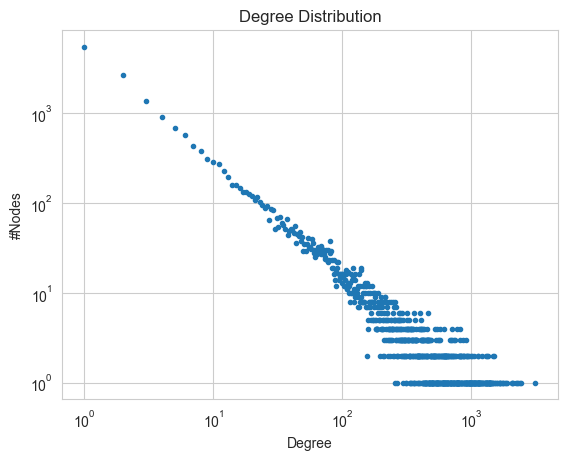

In [10]:
print("Graph")
plot_powerlaw(G)

Graph Sampling
Nodos originales: 20357, Nodos reducidos: 18000
Aristas originales: 518212, Aristas reducidas: 515383
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 62.651484430025825


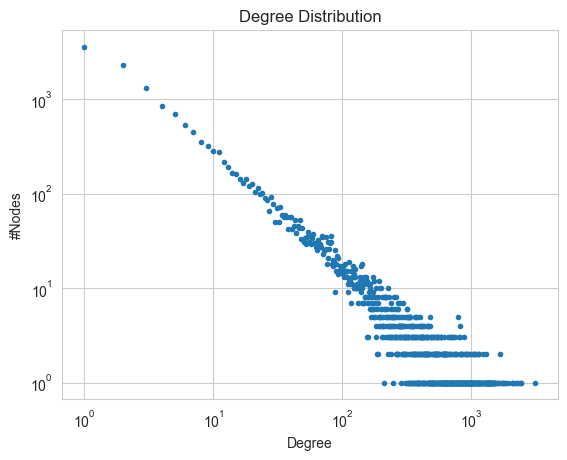

In [11]:
print("Graph Sampling")
G = graph_sampling(G, 18_000)
show_weight(G)
plot_powerlaw(G)

Edge Shedding
Aristas eliminadas: 206154
Nodos: 9257, Aristas: 309229
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 75.5682196689185


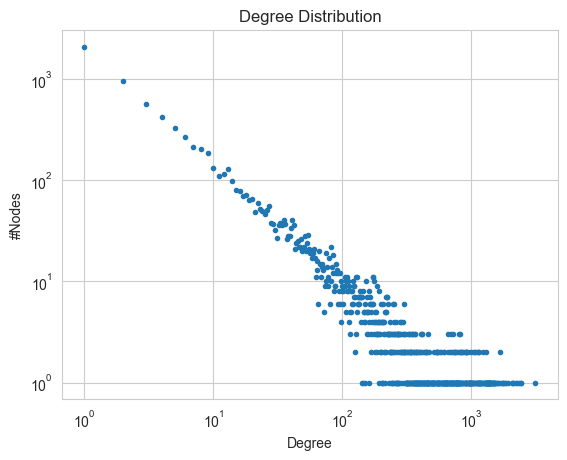

In [12]:
print("Edge Shedding")
G = edge_shedding(G)
show_weight(G)
plot_powerlaw(G)

# Plot Graph


In [13]:
def generate_rgb(seed: int) -> str:
    # return "#xxxxx"
    random.seed(seed)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"

In [14]:
# Generate g with weights
g = nx.Graph()
for u, v, data in G.iterEdgesWeights():
    g.add_edge(u, v, weight=data)

In [15]:
nodes_size = [g.degree(node) * 1.65 for node in g.nodes()]  # type: ignore

In [16]:
hubs, _ = nx.hits(g, max_iter=100, tol=1e-08, normalized=True)
# hubs = set(hubs.keys())

# Ordenar los nodos por sus puntajes de hub en orden descendente
sorted_hubs = sorted(hubs.items(), key=lambda item: item[1], reverse=True)

# Definir cuántos hubs principales seleccionar (ejemplo: top 3 hubs)
top_n = 10
top_hubs = sorted_hubs[:top_n]

In [17]:
# see artist with hubs
print("Top Hubs")
for node, score in top_hubs:
    print(f"Node: {node}, Score: {score}")
    print(f"Artist: { ARTISTS_BY_INDEX[node]}")

Top Hubs
Node: 211, Score: 0.033516026838323276
Artist: Drake
Node: 538, Score: 0.01855848533340836
Artist: Kanye_West
Node: 224, Score: 0.01729817647570411
Artist: Kendrick_Lamar
Node: 540, Score: 0.01717044169435732
Artist: Future
Node: 212, Score: 0.013228321703648493
Artist: Big_Sean
Node: 219, Score: 0.012768297256989273
Artist: J._Cole
Node: 109, Score: 0.012379926747106518
Artist: Rihanna
Node: 423, Score: 0.012117461306387148
Artist: The_Weeknd
Node: 210, Score: 0.011774911355008556
Artist: Migos
Node: 229, Score: 0.011052717566995279
Artist: Rae_Sremmurd


In [18]:
hubs = [node for node, _ in top_hubs]

In [19]:
nodes_color = [
    generate_rgb(100) if node in hubs else generate_rgb(120) for node in g.nodes()
]

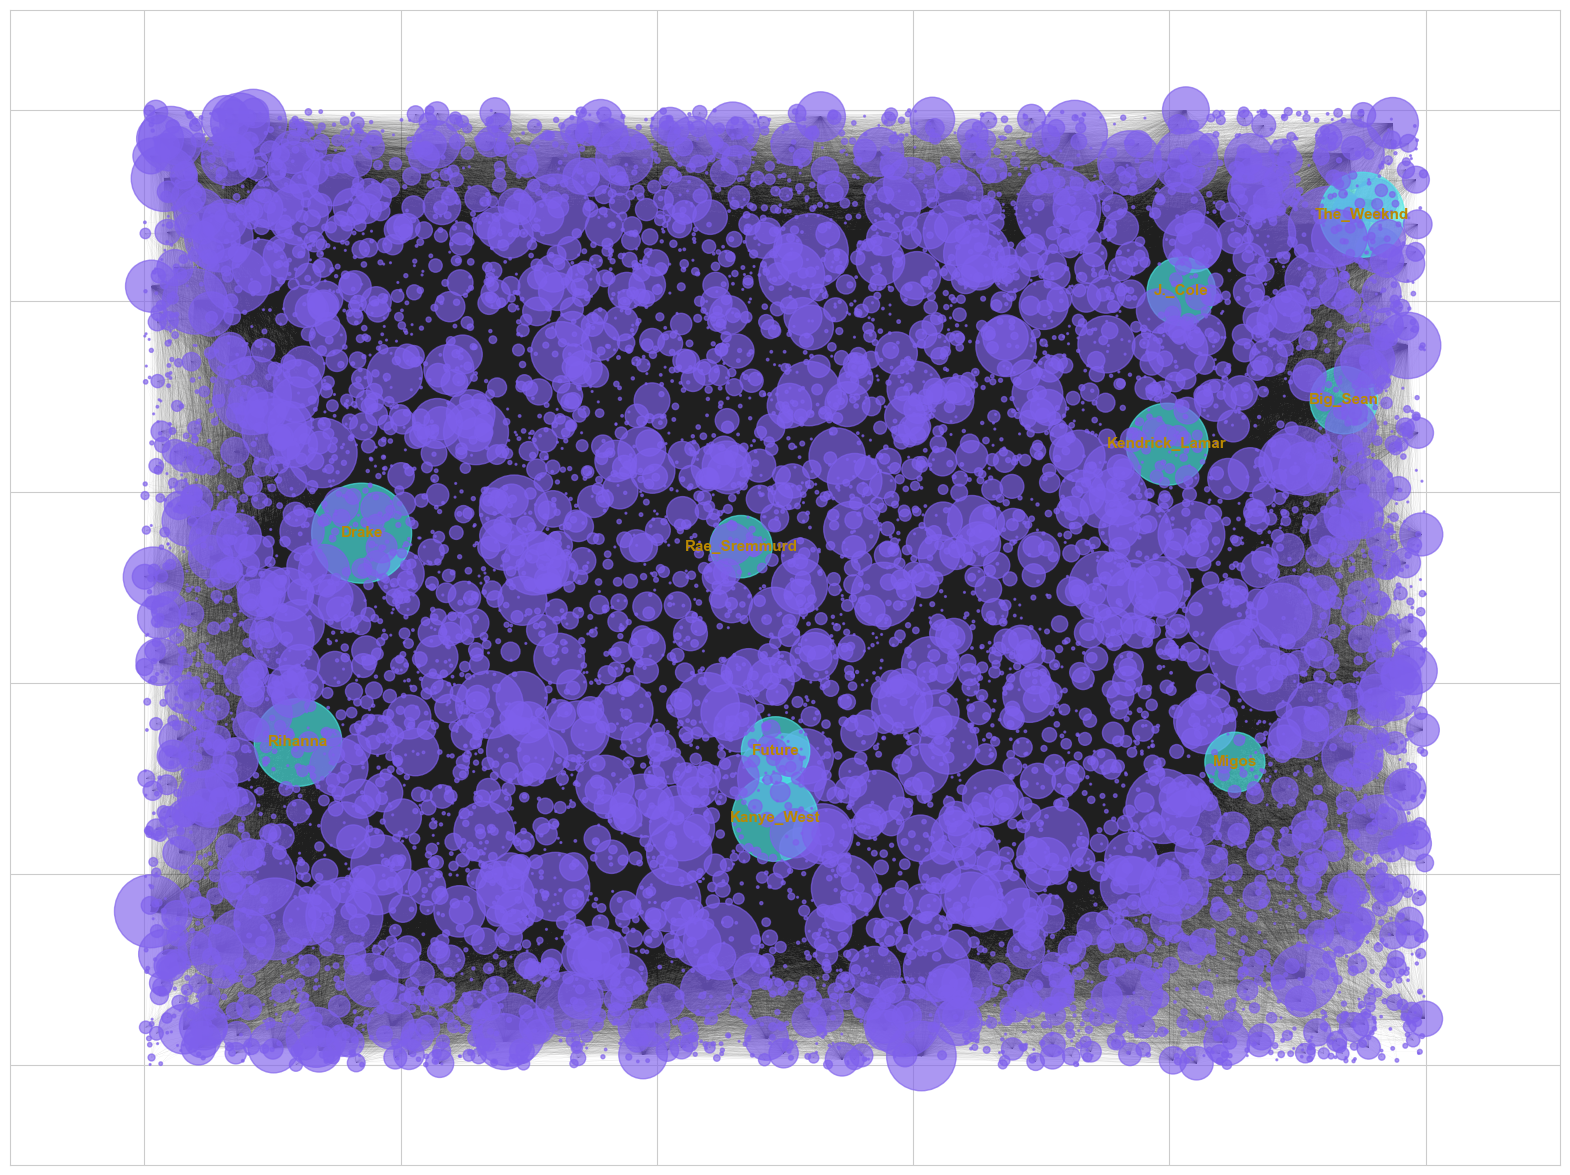

In [20]:
# Aumentar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Calcular la posición de los nodos
pos = nx.random_layout(g, seed=42)

# Dibujar los nodos
nx.draw_networkx_nodes(g, pos, node_size=nodes_size, node_color=nodes_color, alpha=0.65)  # type: ignore

# Dibujar las aristas
nx.draw_networkx_edges(g, pos, width=0.1, alpha=0.1, edge_color="#1f1f1f")

# Dibujar etiquetas para los hubs
nx.draw_networkx_labels(
    g,
    pos,
    labels={node: ARTISTS_BY_INDEX[node] for node in hubs},
    font_size=11,
    font_color="#ba8902",
    font_weight="bold",
)

# Mostrar la gráfica
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


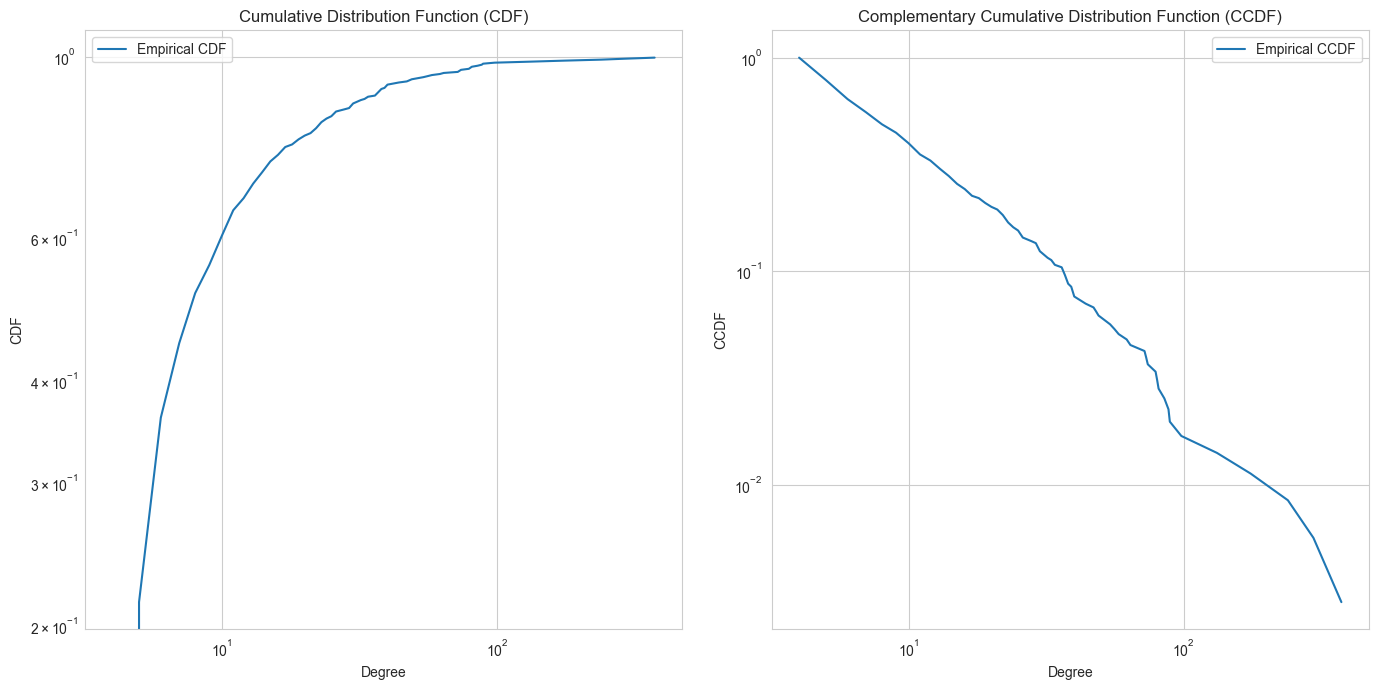

In [21]:
def plot_dist(G):
    M = nx.to_scipy_sparse_array(
        G
    )  # Convertimos el grafo a una matriz dispersa de scipy
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0)  # Suma de los grados de entrada
    degree = np.bincount(
        indegrees.astype(int)
    )  # Asegúrate de convertir los grados a enteros
    fit = powerlaw.Fit(np.array(degree), fit_method="KS")

    fig = plt.figure(figsize=(20, 7))

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf(label="Empirical CDF")
    plt.xlabel("Degree")
    plt.ylabel("CDF")
    plt.title("Cumulative Distribution Function (CDF)")
    plt.legend()

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf(label="Empirical CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF")
    plt.title("Complementary Cumulative Distribution Function (CCDF)")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Ahora puedes llamar a la función con tu grafo g
plot_dist(g)

In [22]:
# save artist index in json
filename = f"../app/public/data/edges/ArtistW_index.json"
print(f"Saving {filename}")
import json

with open(filename, "w") as f:
    json.dump(ARTISTS_BY_INDEX, f)

# Saave artist name in json
filename = f"../app/public/data/edges/ArtistW_name.json"
print(f"Saving {filename}")
with open(filename, "w") as f:
    json.dump(ARTISTS_BY_NAME, f)

Saving ../app/public/data/edges/ArtistW_index.json
Saving ../app/public/data/edges/ArtistW_name.json


## See comunity structure


In [ ]:
# find comunities with Networkit
print("Community Detection")
# Crear una instancia del algoritmo de detección de comunidades
algo = nk.community.PLM(G, refine=True, gamma=2.5)

# Detectar comunidades usando el algoritmo especificado
communities = nk.community.detectCommunities(G, algo=algo)

# Obtener los nodos de cada comunidad
for i, community in enumerate(communities.getSubsetIds()):
    nodes = communities.getMembers(community)
    print(f"Comunidad {i}: {nodes}")

# Explain the values of the modularity
# Modularity is a measure of the strength of division of a network into communities
# It quantifies the quality of the division of a network into communities
# A higher modularity score indicates a better division of the network into communities
# Modularity is a value between -1 and 1, where 1 indicates a perfect division of the network into communities
# In this case we got 0.30 and means that the division of the network into communities is good but not perfect

Community Detection
Communities detected in 0.09076 [s]
solution properties:
-------------------  --------------
# communities          20
min community size    112
max community size   1122
avg. community size   462.85
imbalance               2.42333
edge cut                1.47206e+07
edge cut (portion)     47.6043
modularity              0.307469
-------------------  --------------
Comunidad 0: {0, 2, 3, 6, 9, 10, 7179, 6156, 13, 6668, 7693, 16, 1553, 4625, 2067, 20, 21, 22, 2069, 8719, 26, 27, 1564, 29, 3610, 33, 5675, 1069, 559, 8753, 7731, 7732, 5685, 1590, 1594, 3643, 3644, 3645, 6203, 5702, 1607, 2632, 3144, 4681, 2635, 3660, 4682, 4683, 4684, 1617, 5207, 1112, 6746, 97, 99, 103, 104, 106, 109, 111, 3697, 4209, 124, 8829, 6270, 4224, 4753, 4754, 2707, 2708, 2709, 1689, 6298, 672, 3744, 4256, 6139, 683, 4268, 4269, 8877, 4785, 691, 694, 695, 696, 699, 701, 3780, 1232, 1746, 1747, 3282, 216, 3803, 3806, 7391, 3809, 2787, 743, 744, 6377, 6381, 8941, 1263, 8946, 7411, 6900, 8439, 2

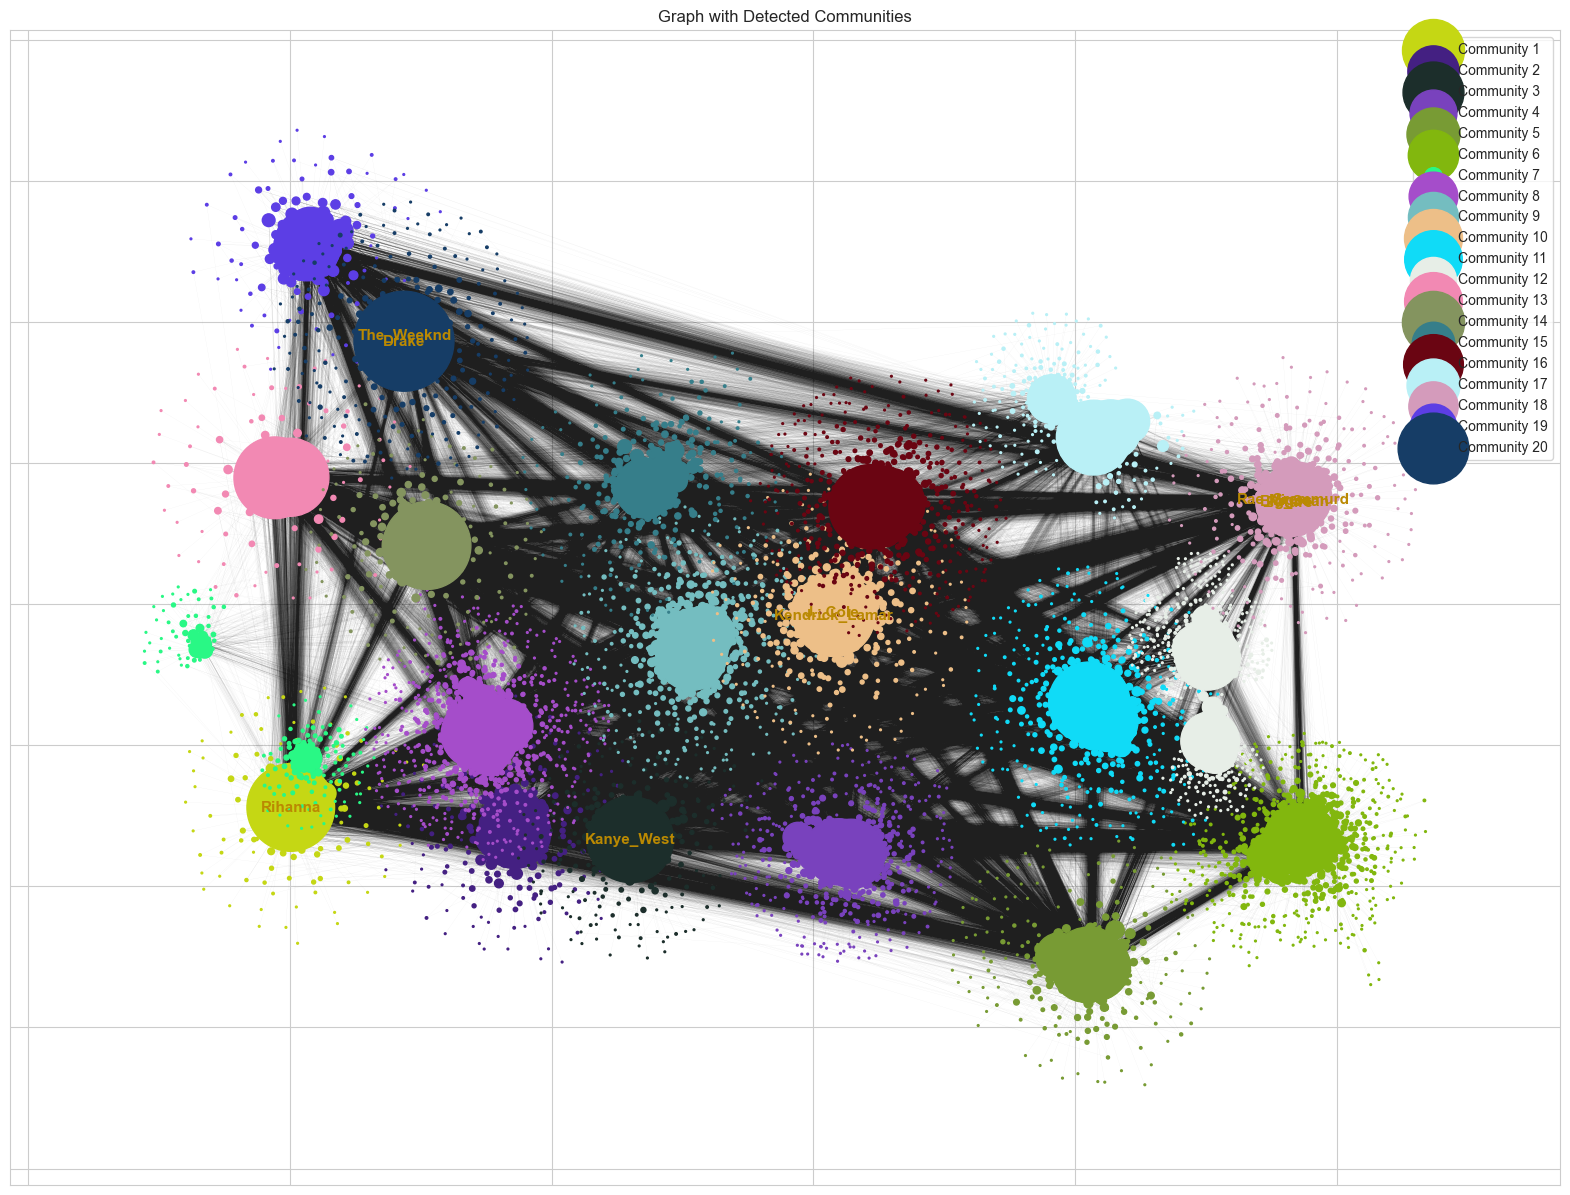

In [55]:
def plot_communities(G, communities):
    pos = {}
    offset_x = 1.5  # Separación horizontal entre comunidades
    offset_y = 1.5  # Separación vertical entre comunidades
    jitter_strength = 0.65  # Fuerza del ruido aleatorio (jitter)
    cols = 6  # Número de columnas para distribuir las comunidades

    for i, community in enumerate(communities.getSubsetIds()):
        nodes = communities.getMembers(community)
        subgraph = G.subgraph(nodes)
        sub_pos = nx.spring_layout(subgraph, seed=42, weight="weight")

        # Calcular desplazamiento en la cuadrícula
        row = i // cols
        col = i % cols
        offset = np.array([col * offset_x, row * offset_y])

        # Agregar jitter aleatorio para romper la regularidad
        jitter = np.random.uniform(-jitter_strength, jitter_strength, 2)
        offset += jitter

        # Offset positions to separate communities
        for node in sub_pos:
            sub_pos[node] += offset

        pos.update(sub_pos)

    plt.figure(figsize=(20, 15))
    colors = [generate_rgb(i) for i in range(communities.numberOfSubsets())]

    for i, community in enumerate(communities.getSubsetIds()):
        nodes = communities.getMembers(community)
        nodes_size = [G.degree(node) * 1.65 for node in nodes]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_color=[colors[i]],
            node_size=nodes_size,
            label=f"Community {i+1}",
        )

    nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.1, edge_color="#1f1f1f")

    # Dibujar etiquetas para los hubs
    nx.draw_networkx_labels(
        G,
        pos,
        labels={
            node: ARTISTS_BY_INDEX[node] for node in hubs
        },  # Debes tener una variable hubs y ARTISTS_BY_INDEX
        font_size=11,
        font_color="#ba8902",
        font_weight="bold",
    )

    plt.legend()
    plt.title("Graph with Detected Communities")
    plt.show()


# Llama a la función
plot_communities(g, communities)

In [90]:
nodes = list(communities.getMembers(5))
print("comunit size: ", len(nodes))
for node in nodes:
    print(f"{ARTISTS_BY_INDEX[node]}")

comunit size:  915
Albert_Hammond,_Jr.
Perfume_Genius
Seoul
White_Lies
TV_On_The_Radio
Bronze_Radio_Return
Dan_Deacon
Laurel
Yeah_Yeah_Yeahs
Guards
Damon_Albarn
Architecture_In_Helsinki
Reptar
Part_Time
Knox_Hamilton
Life_in_Film
Atlas_Sound
The_Knife
Little_Comets
Zerbin
The_New_Pornographers
Little_Joy
Lovage
Get_Set_Go
Parade_of_Lights
Earl_St._Clair
Ursula_1000
Tennyson
Jai_Paul
Discovery
Banes_World
No_Vacation
Grizzly_Bear
Vampire_Weekend
Dr._Dog
Groove_Armada
Mr_Twin_Sister
Crash_Kings
Evenings
The_War_On_Drugs
The_Young_Wild
Lauren_O'Connell
DJ_Krush
Fever_Ray
Lucy_Dacus
Primal_Scream
Polock
Fly_Golden_Eagle
Breton
Thao_&_The_Get_Down_Stay_Down
Jagwar_Ma
Cass_McCombs
SALES
Nneka
Tame_Impala
Arctic_Monkeys
Kate_Nash
Slow_Hollows
HAIM
Banks
London_Grammar
El_Ten_Eleven
FC_Kahuna
Hammock
Ólafur_Arnalds
Helios
Cage_The_Elephant
Catfish_and_the_Bottlemen
The_Kooks
Cold_War_Kids
Kings_of_Leon
Florence_+_The_Machine
The_Front_Bottoms
Beans_&_Fatback
BoomBox
Portugal._The_Man
alt-J
Gro

In [51]:
# Crear un diccionario para almacenar la importancia de cada nodo
node_importance = {}

for community_id in set(communities.getSubsetIds()):
    # Obtener los nodos de la comunidad actual
    nodes_in_community = communities.getMembers(community_id)
    subgraph = g.subgraph(nodes_in_community)

    # Calcular la centralidad de grado dentro de la comunidad
    centrality = nx.degree_centrality(subgraph)

    # Almacenar la centralidad en el diccionario
    for node, central in centrality.items():
        node_importance[node] = central

# calculate the max and min
max_importance = max(node_importance.values())
min_importance = min(node_importance.values())

print(f"Max Importance: {max_importance}, Min Importance: {min_importance}")

# Scale the values between 1 and 0.1
scaled_importance = {
    node: 0.1
    + (0.9 * (importance - min_importance) / (max_importance - min_importance))
    for node, importance in node_importance.items()
}

# calculate again the max and min
max_importance = max(scaled_importance.values())
min_importance = min(scaled_importance.values())

print(
    f"Max Importance Scaled: {max_importance}, Min Importance Scaled: {min_importance}"
)

Max Importance: 0.9341085271317829, Min Importance: 0.0008920606601248885
Max Importance Scaled: 1.0, Min Importance Scaled: 0.1


In [52]:
# Create the map for each node asign his comunity
nodes = list(g.nodes())
# Assign the comunity
nodeComunity = {}
for com in communities.getSubsetIds():
    comunity = com,communities.getMembers(com)
    for node in comunity[1]:
        nodeComunity[node] = comunity[0]
        
print(nodeComunity)

{0: 0, 2: 0, 3: 0, 6: 0, 9: 0, 10: 0, 7179: 0, 6156: 0, 13: 0, 6668: 0, 7693: 0, 16: 0, 1553: 0, 4625: 0, 2067: 0, 20: 0, 21: 0, 22: 0, 2069: 0, 8719: 0, 26: 0, 27: 0, 1564: 0, 29: 0, 3610: 0, 33: 0, 5675: 0, 1069: 0, 559: 0, 8753: 0, 7731: 0, 7732: 0, 5685: 0, 1590: 0, 1594: 0, 3643: 0, 3644: 0, 3645: 0, 6203: 0, 5702: 0, 1607: 0, 2632: 0, 3144: 0, 4681: 0, 2635: 0, 3660: 0, 4682: 0, 4683: 0, 4684: 0, 1617: 0, 5207: 0, 1112: 0, 6746: 0, 97: 0, 99: 0, 103: 0, 104: 0, 106: 0, 109: 0, 111: 0, 3697: 0, 4209: 0, 124: 0, 8829: 0, 6270: 0, 4224: 0, 4753: 0, 4754: 0, 2707: 0, 2708: 0, 2709: 0, 1689: 0, 6298: 0, 672: 0, 3744: 0, 4256: 0, 6139: 0, 683: 0, 4268: 0, 4269: 0, 8877: 0, 4785: 0, 691: 0, 694: 0, 695: 0, 696: 0, 699: 0, 701: 0, 3780: 0, 1232: 0, 1746: 0, 1747: 0, 3282: 0, 216: 0, 3803: 0, 3806: 0, 7391: 0, 3809: 0, 2787: 0, 743: 0, 744: 0, 6377: 0, 6381: 0, 8941: 0, 1263: 0, 8946: 0, 7411: 0, 6900: 0, 8439: 0, 2810: 0, 8442: 0, 8449: 0, 2821: 0, 4358: 0, 2826: 0, 6411: 0, 7947: 0, 385

In [53]:
# Agrega value to the grap ()
nx.set_node_attributes(g, scaled_importance, "importance")
# Agrega comnidad
nx.set_node_attributes(g, nodeComunity, "community")

In [54]:
import networkx as nx

# Agrega atributos a los nodos
nx.set_node_attributes(g, scaled_importance, "importance")

# Guardar el grafo en formato GraphML
filename = "../app/public/data/graph.graphml"
print(f"Saving {filename}")
nx.write_graphml(g, filename, encoding="utf-8", prettyprint=True, )

Saving ../app/public/data/graph.graphml
